In [ ]:
import datetime
import matplotlib.pyplot as plt

# pandas_datareader爬取A股数据

In [36]:
import pandas_datareader.data as web

start = datetime.datetime(2015,1,1)#获取数据的时间段-起始时间
end = datetime.date.today()#获取数据的时间段-结束时间

stock = web.DataReader("300783.SZ", "yahoo", start, end) #SZ深证 SA上证
stock_hegu = web.DataReader("300783.SZ", "yahoo-actions", start, end) # 合股
stock_fenhong = web.DataReader("300783.SZ", "yahoo-dividends", start, end) #分红
stock_hangqing=web.get_quote_yahoo("300783.SZ").T #该只股票的行情数据

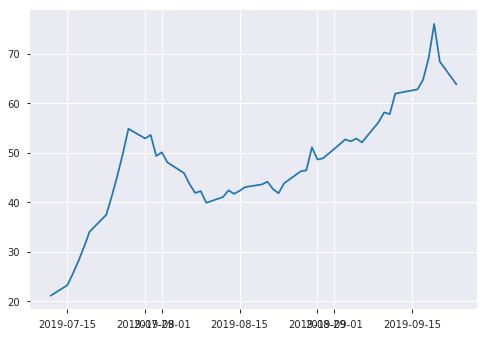

In [31]:
plt.plot(stock.Close)

In [39]:
stock.describe()

,High,Low,Open,Close,Volume,Adj Close
count,52.000000,52.000000,52.000000,52.000000,5.200000e+01,52.000000
mean,49.160192,46.336923,47.316154,48.049231,7.894253e+06,48.049231
std,12.246569,10.722049,11.277797,11.639863,5.575635e+06,11.639863
min,21.139999,17.620001,17.620001,21.139999,1.646700e+04,21.139999
25%,43.084999,41.352501,42.045001,42.175000,5.063370e+06,42.175000
50%,49.109999,46.134998,47.530001,47.260000,7.733346e+06,47.260000
75%,53.914999,51.802500,52.767500,53.075001,1.032565e+07,53.075001
max,78.239998,68.430000,75.959999,76.029999,2.412368e+07,76.029999


## pandas_profiling看全盘数据分析

In [6]:
import pandas_profiling   # pandas-profiling 生产详细的数据报告
profile=stock.profile_report(title='test')
profile.to_file(output_file='test.html')

# 获取天天基金数据

          净值日期    单位净值    累计净值  日增长率  申购状态  赎回状态 分红送配
0   2018-01-02  13.733  17.913  1.22  开放申购  开放赎回  nan
1   2018-01-03  13.718  17.898 -0.11  开放申购  开放赎回  nan
2   2018-01-04  13.791  17.971  0.53  开放申购  开放赎回  nan
3   2018-01-05  13.925  18.105  0.97  开放申购  开放赎回  nan
4   2018-01-08  13.941  18.121  0.11  开放申购  开放赎回  nan
5   2018-01-09  14.069  18.249  0.92  开放申购  开放赎回  nan
6   2018-01-10  14.140  18.320  0.50  开放申购  开放赎回  nan
7   2018-01-11  14.082  18.262 -0.41  开放申购  开放赎回  nan
8   2018-01-12  14.211  18.391  0.92  开放申购  开放赎回  nan
9   2018-01-15  14.312  18.492  0.71  开放申购  开放赎回  nan
10  2018-01-16  14.412  18.592  0.70  开放申购  开放赎回  nan
11  2018-01-17  14.185  18.365 -1.58  开放申购  开放赎回  nan
12  2018-01-18  14.195  18.375  0.07  开放申购  开放赎回  nan
13  2018-01-19  14.068  18.248 -0.89  开放申购  开放赎回  nan
14  2018-01-22  14.373  18.553  2.17  开放申购  开放赎回  nan
15  2018-01-23  14.443  18.623  0.49  开放申购  开放赎回  nan
16  2018-01-24  14.365  18.545 -0.54  开放申购  开放赎回  nan
17  2018-01-25  14.290  18.4

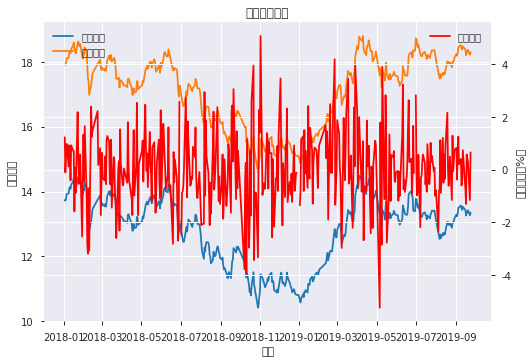

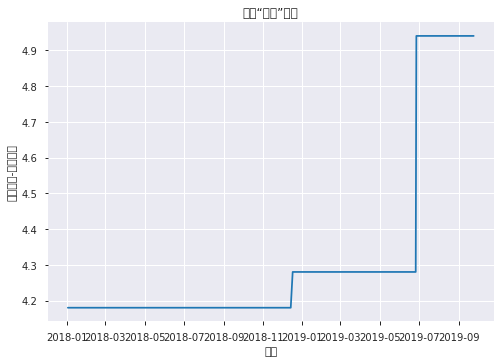

日增长率缺失： 3
日增长率为正的天数： 199
日增长率为负（包含0）的天数： 223


In [45]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

# 抓取网页
def get_url(url, params=None, proxies=None):
    rsp = requests.get(url, params=params, proxies=proxies)
    rsp.raise_for_status()
    return rsp.text

# 从网页抓取数据
def get_fund_data(code,per=10,sdate='',edate='',proxies=None):
    url = 'http://fund.eastmoney.com/f10/F10DataApi.aspx'
    params = {'type': 'lsjz', 'code': code, 'page':1,'per': per, 'sdate': sdate, 'edate': edate}
    html = get_url(url, params, proxies)
    soup = BeautifulSoup(html, 'html.parser')

    # 获取总页数
    pattern=re.compile(r'pages:(.*),')
    result=re.search(pattern,html).group(1)
    pages=int(result)

    # 获取表头
    heads = []
    for head in soup.findAll("th"):
        heads.append(head.contents[0])

    # 数据存取列表
    records = []

    # 从第1页开始抓取所有页面数据
    page=1
    while page<=pages:
        params = {'type': 'lsjz', 'code': code, 'page':page,'per': per, 'sdate': sdate, 'edate': edate}
        html = get_url(url, params, proxies)
        soup = BeautifulSoup(html, 'html.parser')

        # 获取数据
        for row in soup.findAll("tbody")[0].findAll("tr"):
            row_records = []
            for record in row.findAll('td'):
                val = record.contents

                # 处理空值
                if val == []:
                    row_records.append(np.nan)
                else:
                    row_records.append(val[0])

            # 记录数据
            records.append(row_records)

        # 下一页
        page=page+1

    # 数据整理到dataframe
    np_records = np.array(records)
    data= pd.DataFrame()
    for col,col_name in enumerate(heads):
        data[col_name] = np_records[:,col]

    return data


# 主程序
if __name__ == "__main__":
    data=get_fund_data('000011',per=1,sdate='2018-01-01',edate='2019-09-24')
    # 修改数据类型
    data['净值日期']=pd.to_datetime(data['净值日期'],format='%Y/%m/%d')
    data['单位净值']= data['单位净值'].astype(float)
    data['累计净值']=data['累计净值'].astype(float)
    data['日增长率']=data['日增长率'].str.strip('%').astype(float)
    # 按照日期升序排序并重建索引
    data=data.sort_values(by='净值日期',axis=0,ascending=True).reset_index(drop=True)
    print(data)

    # 获取净值日期、单位净值、累计净值、日增长率等数据并
    net_value_date = data['净值日期']
    net_asset_value = data['单位净值']
    accumulative_net_value=data['累计净值']
    daily_growth_rate = data['日增长率']

    # 作基金净值图
    fig = plt.figure()
    #坐标轴1
    ax1 = fig.add_subplot(111)
    ax1.plot(net_value_date,net_asset_value)
    ax1.plot(net_value_date,accumulative_net_value)
    ax1.set_ylabel('净值数据')
    ax1.set_xlabel('日期')
    plt.legend(loc='upper left')
    #坐标轴2
    ax2 = ax1.twinx()
    ax2.plot(net_value_date,daily_growth_rate,'r')
    ax2.set_ylabel('日增长率（%）')
    plt.legend(loc='upper right')
    plt.title('基金净值数据')
    plt.show()

    # 绘制分红配送信息图
    bonus = accumulative_net_value-net_asset_value
    plt.figure()
    plt.plot(net_value_date,bonus)
    plt.xlabel('日期')
    plt.ylabel('累计净值-单位净值')
    plt.title('基金“分红”信息')
    plt.show()

    # 日增长率分析
    print('日增长率缺失：',sum(np.isnan(daily_growth_rate)))
    print('日增长率为正的天数：',sum(daily_growth_rate>0))
    print('日增长率为负（包含0）的天数：',sum(daily_growth_rate<=0))